## Bulk RNA-Seq Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
import math
import pathlib
from functools import reduce    

plt.rcParams["font.family"] = "Arial"
sns.set_theme(style="white")

In [33]:
# specify file path
data_path = pathlib.Path("/Users/henrysanford/Dropbox @RU Dropbox/Vinogradova Laboratory/Exhaustion manuscript/01_RNA-sequencing/PIP5K1-KO")
df_path = data_path / "normalized_counts.tsv"

### Principal component analysis

In [34]:
def run_and_plot_pca(data_df, output_path):
    pathlib.Path(output_path).mkdir(exist_ok = True)
    # log transform the data
    df_log = np.log2(data_df)
    number_of_proteins_in_common = df_log.shape[0]
    df_log = df_log.replace(-np.inf, np.nan)
    df_log = df_log.dropna()
    # transpose data
    df_log_t = df_log.transpose()
    df_log_t.reset_index(inplace=True)
    df_log_t = df_log_t.rename(columns={"index":"sample_name"})
    df_log_t.sample(5)
    # prepare subset dataframes for pc analysis
    X = df_log_t.drop('sample_name', axis=1)
    X.sample(5)
    y = df_log_t['sample_name']
    # specify number of components and fit transform
    pca = PCA(n_components=5)
    principal_components = pca.fit_transform(X)
    # create prinicpal component dataframe
    principal_components_df = pd.DataFrame(data = principal_components,
                                        columns = ['PC1','PC2','PC3','PC4', 'PC5'])
    principal_components_df = pd.concat([principal_components_df, y], axis = 1)
    principal_components_df.head(5)
    # add metadata information
    principal_components_df["condition"] = principal_components_df["sample_name"].apply(lambda a: a.split("_")[1].split("_")[0][:-2].replace(".","_"))
    principal_components_df
    # create barplot of explained variance
    sns.barplot(x=['PC1','PC2','PC3','PC4', 'PC5'],
            y=(pca.explained_variance_ratio_)*100,
            edgecolor = 'black',
            palette = 'YlGnBu').set(title='Principal Components', ylabel='Percent (%)')
    plt.show()
    plt.savefig(output_path / "principal_components.svg")
    # get PCA loadings dataframe
    loadings_df = pd.DataFrame(data = np.transpose(pca.components_), columns = ['PC1','PC2','PC3','PC4','PC5'])
    X = df_log_t.drop('sample_name', axis=1)
    loadings_df["variable"] = list(X.columns)
    # specify range of plot, symbold and colors
    
    symbols = ["circle", "triangle-up"]
    rename_conditions = {
        "D2" : "D2",
        "D4_Ac":"D4A",
        "D4_Chr":"D4C",
        "D8_Ac":"D8A",
        "D8_Chr":"D8C"
    }
    principal_components_df['condition'] = principal_components_df["condition"].replace(rename_conditions)
    color_discrete_map = {
        "D2": "#F9A05C",
        "D4A": "#47C6E7",
        "D4C": "#F06691",
        "D8A": "#B9D982",
        "D8C": "#DA9EC7"
    }
    principal_components_df.to_csv(output_path / "principal_components.csv")
    # create pca plot
    fig = px.scatter(principal_components_df,
                    x='PC1',
                    y='PC2',
                    hover_data=['sample_name'],
                    color=principal_components_df['condition'],
                    color_discrete_map=color_discrete_map,
                    labels={"PC1": "PC1 ({}%)".format(round((pca.explained_variance_ratio_[0] * 100),2)),
                            "PC2": "PC2 ({}%)".format(round((pca.explained_variance_ratio_[1] * 100),2)),
                            "species": "Species"},
                    title="PCA plot" +" ("+str(number_of_proteins_in_common)+" Genes)",
                    template="plotly_white",
                    category_orders={"condition": ['D2', 'D4A', 'D4C', 'D8A', 'D8C']})
    
    #updates the range of x and y axis
    fig.update_xaxes(dtick=4, range=[principal_components_df["PC1"].min() - 2, principal_components_df["PC1"].max() + 2])
    fig.update_yaxes(dtick=4, range=[principal_components_df["PC2"].min() - 2, principal_components_df["PC2"].max() + 2])
    
    #determines if border of plot should be shown
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
    
    #determines gridlines details
    fig.update_xaxes(showgrid=True, gridwidth=2, gridcolor='#E8E8E8')
    fig.update_yaxes(showgrid=True, gridwidth=2, gridcolor='#E8E8E8')
    
    #determines how zerolines should be displayed
    fig.update_xaxes(zerolinewidth=2, zerolinecolor='#E8E8E8')
    fig.update_yaxes(zerolinewidth=2, zerolinecolor='#E8E8E8')
    
    #updates size of feature points in plot
    fig.update_traces(marker=dict(size=12),
                    selector=dict(mode='markers'))
    
    #specifies layout details
    fig.update_layout(height=500,
                    width=600,
                    showlegend=True,
                    legend_title_text='Condition',
                    font=dict(family="Arial",
                              color="black"),
                    title_x=0.45)
    
    fig.write_html(output_path / "pca_plot.html")
    fig.write_image(output_path / "pca_plot.svg")
    #fig.savefig("pca_plot.png")
    fig.show()
    # get one laodings worth, rememeber sum of squares per PC loading = 1
    one_loading_value = math.sqrt(1/len(loadings_df))
    # then filter out ones that contribute more than one variables worth
    filtered_loadings = loadings_df[(loadings_df["PC1"] > one_loading_value) | (loadings_df["PC1"] < -one_loading_value) | (loadings_df["PC2"] > one_loading_value) | (loadings_df["PC2"] < -one_loading_value)]
    
    top_pos_PC1_df = filtered_loadings.sort_values('PC1', ascending=False).head(10)
    top_neg_PC1_df = filtered_loadings.sort_values('PC1').head(10)
    
    top_pos_PC2_df = filtered_loadings.sort_values('PC2', ascending=False).head(10)
    top_neg_PC2_df = filtered_loadings.sort_values('PC2').head(10)
    
    df_list = [top_pos_PC1_df, top_neg_PC1_df, top_pos_PC2_df, top_neg_PC2_df]
    
    merged_loadings_df = reduce(lambda x, y: pd.merge(x[["variable", "PC1", "PC2"]], y[["variable", "PC1", "PC2"]], on = ["variable", "PC1", "PC2"],  how = "outer"), df_list)
    merged_loadings_df.head(5)
    # add loadings to pca plot
    n = merged_loadings_df.shape[0]
    for i in range(n):
        fig.add_annotation(x= 0,
                        y= 0,
                        ax=merged_loadings_df.iloc[i,1] * 80,
                        ay=merged_loadings_df.iloc[i,2] * 80,
                        xref='x',
                        yref='y',
                        axref='x',
                        ayref='y',
                        text=merged_loadings_df.iloc[i,0],
                        showarrow=True,
                        arrowhead=3,
                        arrowsize=1,
                        arrowwidth=1,
                        arrowcolor='red',
                        opacity=0.6,
                        arrowside='start')
    
    fig.write_html(output_path / "pca_plot_with_loadings.html")
    fig.show()
    # create heatmap of loadings P
    plt.figure(figsize=(5,8))
    sns.heatmap(merged_loadings_df.set_index("variable"),
            cmap='YlGnBu',
            linewidths=0.7,
            linecolor="black").set(title='Loadings', ylabel=None)
    plt.savefig(output_path /  "loadings_heatmap.svg", bbox_inches='tight')
    plt.show()
    loadings_df.to_csv(output_path / "loadings_df.csv")


/Users/henrysanford/miniconda/envs/exhaustion/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

divide by zero encountered in log2

/var/folders/_y/ykkyh0zs03x3r9jzl6tpc7rm0000gq/T/ipykernel_14252/4273115286.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




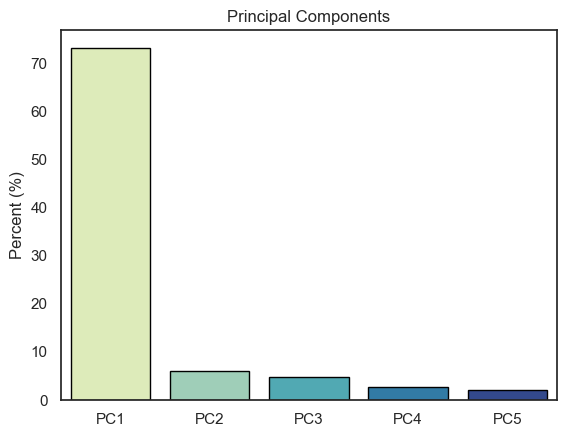

<Figure size 640x480 with 0 Axes>

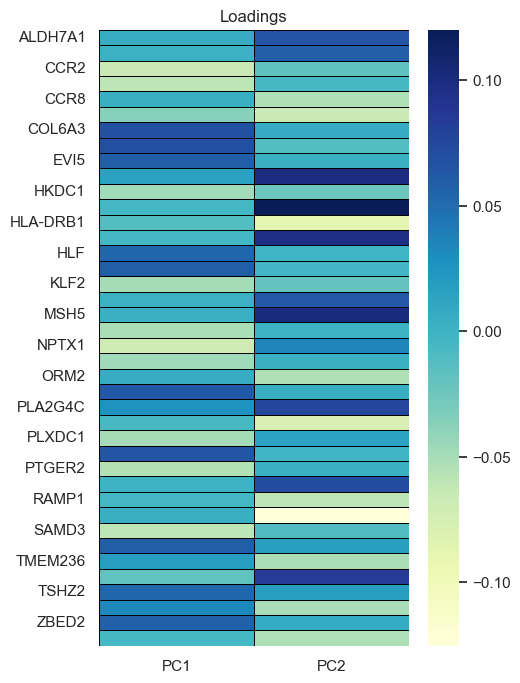

In [35]:
# filter to protein coding genes, then filter to top 5000 highest variance genes
results_dir = data_path / "PCA_5000_genes"
results_dir.mkdir(exist_ok=True)
df = pd.read_csv(df_path, index_col=[0], sep="\t")
gene_id_df = pd.read_csv("mart_export.txt", sep="\t")
protein_coding_genes = gene_id_df[gene_id_df["Gene type"] == "protein_coding"]
gene_stable_ids = set(protein_coding_genes["Gene stable ID"])
gene_names = set(protein_coding_genes["Gene name"])
gene_synonyms = set(protein_coding_genes["Gene Synonym"])
protein_coding_counts = []
for i,r in df.iterrows():
    if (i in gene_stable_ids) or (i in gene_names) or (i in gene_synonyms):
        protein_coding_counts.append(r)
df = pd.DataFrame(protein_coding_counts)

df["variance"] = np.var(df, axis = 1)
df = df.sort_values("variance")
df = df.tail(20000)
df = df.drop(["variance"], axis=1)
df.to_csv(results_dir / "normalized_counts_5000_protein_coding_genes.csv")


run_and_plot_pca(df, results_dir)

### Format data table

In [36]:
normalized_counts = pd.read_csv(df_path, sep = "\t")

rename_conditions = {"D4_Ac": "D4A", "D4_Chr": "D4C", "D8_Ac": "D8A", "D8_Chr": "D8C"}

formatted_colnames = []

for column in normalized_counts.columns:
    for condition, formatted_condition in rename_conditions.items():
        column = column.replace(condition.replace("_", "."), formatted_condition)
    formatted_colnames.append(column)
normalized_counts.columns = formatted_colnames
normalized_counts.index.name = "gene_name"
normalized_counts

# attatch RNA-Seq data
dgea_rnaseq_data_dir_path = pathlib.Path(
    "/Users/henrysanford/Dropbox @RU Dropbox/Vinogradova Laboratory/Exhaustion manuscript/02_Mass-spectrometry data/00_rnaseqdata_from_Jahan/13524/results_deseq2"
)
control_condition = "D2"

rna_data = []
for condition, formatted_condition in rename_conditions.items():
    rna_df = (
        pd.read_csv(
            dgea_rnaseq_data_dir_path
            / "13524_pc_genes_{}_{}_results.csv".format(
                condition.replace("_", "-"), control_condition
            ),
            index_col = 0
        )
        .rename(
            columns=lambda x: x
            + "_{}_vs_{}".format(formatted_condition, control_condition)
        )  # suffix indicating source
    )  # rename column to join on
    rna_df.index.name = "gene_name"
    rna_data.append(rna_df.reset_index())

"""
    normalized_counts = normalized_counts.merge(
        right=rna_df, 
        left_index=True,
        right_index=True
    )

"""
final_table = reduce(
    lambda left, right: pd.merge(
        left,
        right,
        on="gene_name",
        how="outer",
    ),
    rna_data,
)

final_table["mean_sums"] = final_table.filter(like = "baseMean").sum(axis=1)
final_table = final_table[final_table["mean_sums"] != 0]

final_table.drop("mean_sums", axis = 1).to_excel(
    "Data S1.xlsx",
    sheet_name="S1-1 Bulk RNA-Sequencing data",
    index=None,
    startrow=2
)

# PIP5K1

In [2]:
import sys

sys.path.append("../../bin/")

from analysis_utils import * 

In [3]:
data_path = Path('/Users/henrysanford/Dropbox @RU Dropbox/Vinogradova Laboratory/Exhaustion manuscript/01_RNA-sequencing/PIP5K1-KO')

results_dir = data_path / "PCA_5000_genes"
results_dir.mkdir(exist_ok=True)

df_path =  data_path / 'FPKM_matrix.txt'
df = pd.read_csv(df_path, index_col=[0], sep="\t")
gene_id_df = pd.read_csv("mart_export.txt", sep="\t")
protein_coding_genes = gene_id_df[gene_id_df["Gene type"] == "protein_coding"]
gene_stable_ids = set(protein_coding_genes["Gene stable ID"])
gene_names = set(protein_coding_genes["Gene name"])
gene_synonyms = set(protein_coding_genes["Gene Synonym"])
protein_coding_counts = []
for i,r in df.iterrows():
    if (i in gene_stable_ids) or (i in gene_names) or (i in gene_synonyms):
        protein_coding_counts.append(r)
df = pd.DataFrame(protein_coding_counts)

df["variance"] = np.var(df, axis = 1)
df = df.sort_values("variance")
df = df.tail(5000)
df = df.drop(["variance"], axis=1)
df.to_csv(results_dir / "normalized_counts_5000_protein_coding_genes.csv")
#df = df.filter(regex="Donor2", axis = 1)

fig, loadings_df, finalDf, percent_df = get_pca_plot(
    df = df.reset_index(names = "Geneid"),
    index_cols = "Geneid",
    title_string = "RNA-Seq",
    out_dir = results_dir,
    with_log = False
)
fig.show()

loadings_df.to_csv(results_dir / "loadings_results.csv")

finalDf.to_csv(results_dir / "pca_results.csv")



/Users/henrysanford/miniconda/envs/exhaustion/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


/Users/henrysanford/miniconda/envs/exhaustion/lib/python3.12/site-packages/gseapy/msigdb.py:29: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/Users/henrysanford/miniconda/envs/exhaustion/lib/python3.12/site-packages/gseapy/msigdb.py:95: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/var/folders/_y/ykkyh0zs03x3r9jzl6tpc7rm0000gq/T/ipykernel_97573/353410664.py:14: DeprecationWarning:

processes is deprecated; use threads

/Users/henrysanford/miniconda/envs/exhaustion/lib/python3.12/site-packages/gseapy/plot.py:738: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('fut

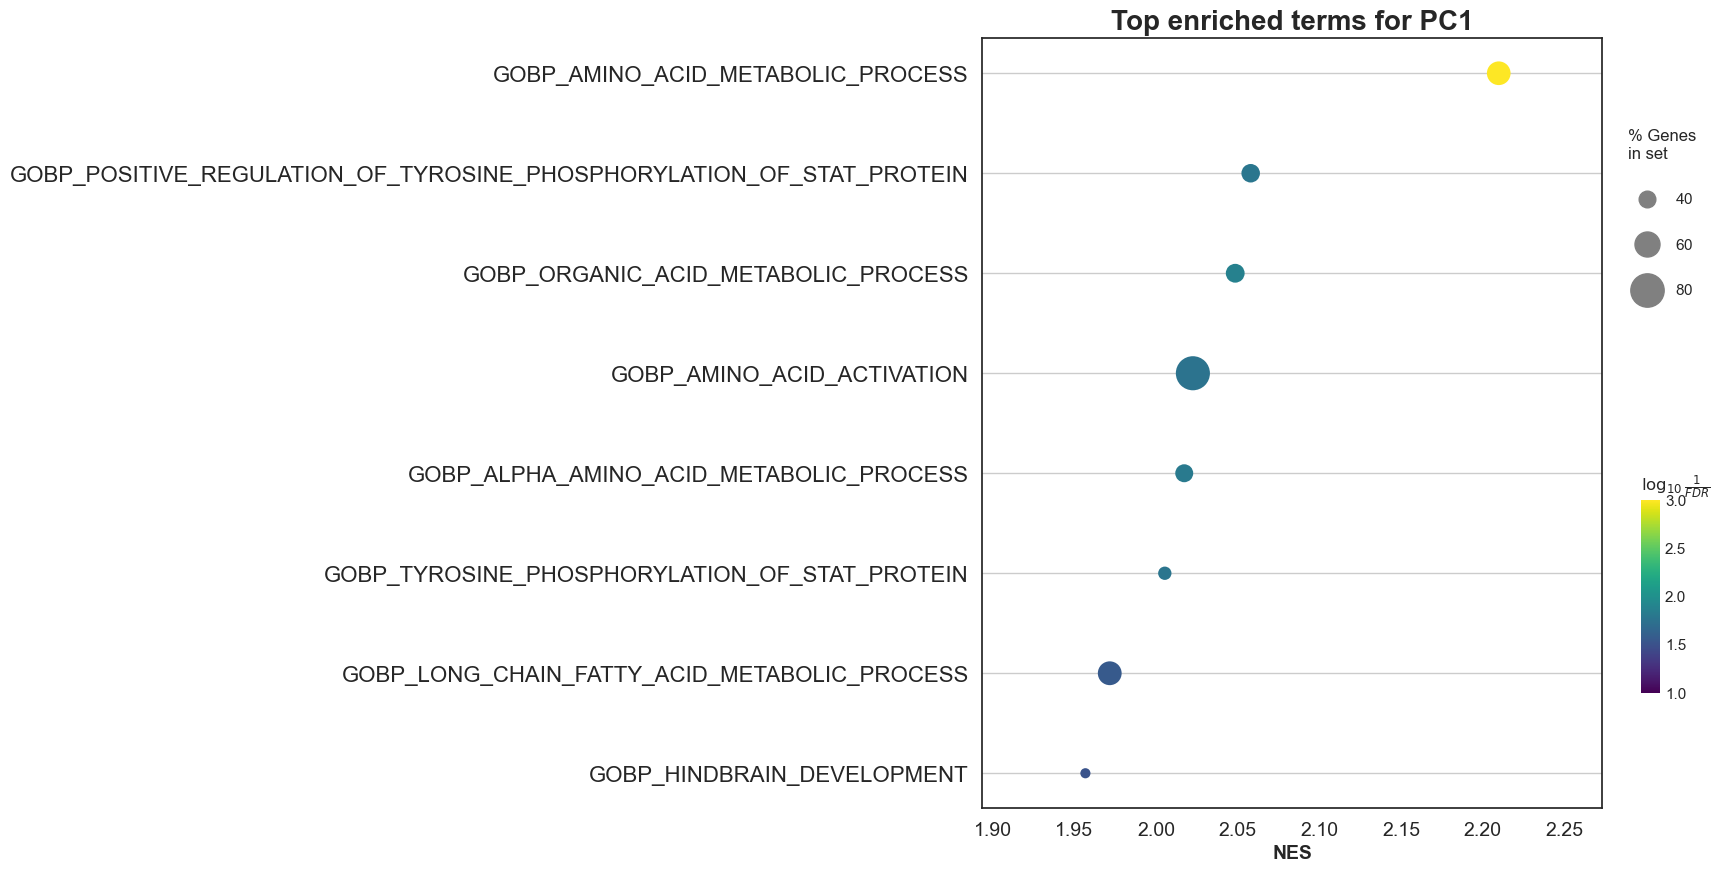

/var/folders/_y/ykkyh0zs03x3r9jzl6tpc7rm0000gq/T/ipykernel_97573/353410664.py:14: DeprecationWarning:

processes is deprecated; use threads

/Users/henrysanford/miniconda/envs/exhaustion/lib/python3.12/site-packages/gseapy/plot.py:738: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/_y/ykkyh0zs03x3r9jzl6tpc7rm0000gq/T/ipykernel_97573/353410664.py:56: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



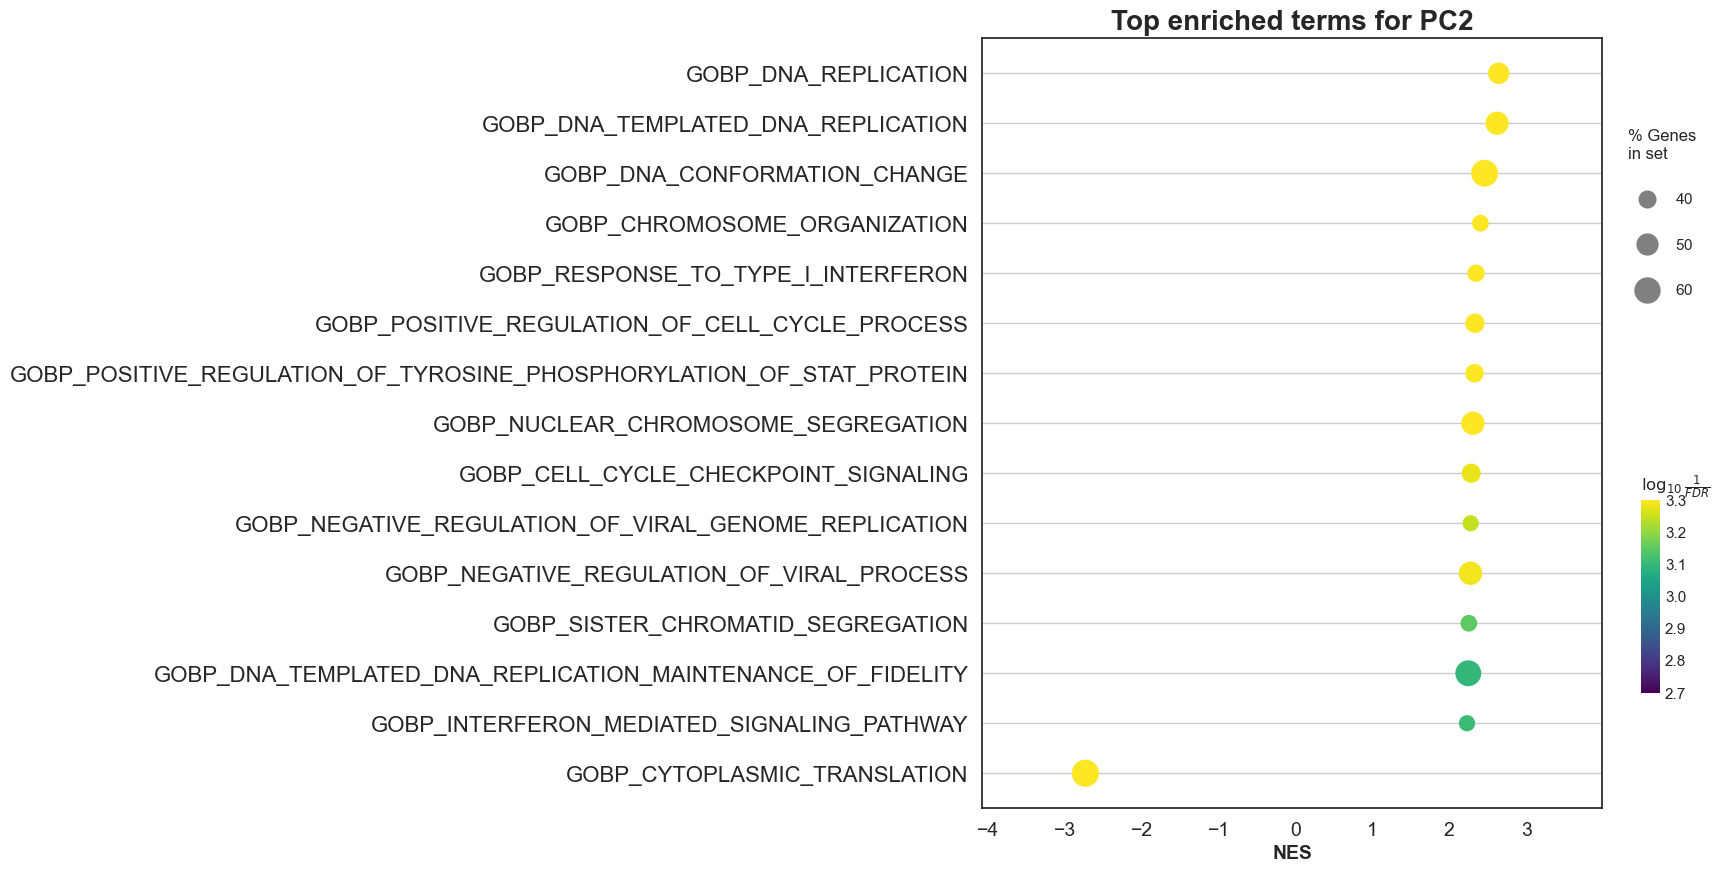

In [4]:
import gseapy as gp
from gseapy import Msigdb
import matplotlib.pyplot as plt


def perform_gsea_proteomics(loading_results, gene_sets, output_dir, pc):
    """
    Perform GSEA on proteomics loading results.
    """
    # Sort proteins by loading score
    ranked_proteins = loading_results.sort_values(ascending=True, by=pc)

    # Perform GSEA
    gsea_results = gp.prerank(
        rnk=ranked_proteins,
        gene_sets=gene_sets,
        processes=4,
        correction="bh",
        permutation_num=1000,
        outdir=output_dir,
        seed=42,
        no_plot=True,
    )

    return gsea_results

msig = Msigdb()
# c5.go.bp = GO biological process
gmt_name = "c5.go.bp"
gmt = msig.get_gmt(gmt_name)


for pc in ["PC1", "PC2"]:
    pc_path = results_dir / pc
    pre_res = perform_gsea_proteomics(
        pd.DataFrame(loadings_df[pc]), gene_sets=gmt, output_dir=pc_path, pc=pc
    )

    df = pre_res.res2d
    df["abs_nes"] = -abs(df["NES"])
    df = df[df["NOM p-val"] < 0.01]

    terms = pre_res.res2d.Term[:10]  # Top 5 enriched terms
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    # Dot plot
    gp.plot.dotplot(
        pre_res.res2d,
        title=f"Top enriched terms for {pc}",
        cmap="viridis",
        size=5,
        top_term=15,
        ax=axes,
        column="FDR q-val",
    )
    plt.tight_layout()
    plt.savefig(
        pc_path / "top_enriched_terms.svg", bbox_inches="tight"
    )
    plt.show()